In [67]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

import pingouin as pg

from tqdm.auto import tqdm

In [68]:
mobile_app = pd.read_csv('hw_aa.csv', sep=';')

In [69]:
# удалим лишний столбец, дублирует индексы
mobile_app = mobile_app.drop('Unnamed: 0', axis=1)

In [70]:
mobile_app.head(2)

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0


In [71]:
# выведем информацию по таблице, видим, что: значения не пропущены, объем и тип данных
mobile_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127018 entries, 0 to 127017
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   uid                127018 non-null  object
 1   experimentVariant  127018 non-null  int64 
 2   version            127018 non-null  object
 3   purchase           127018 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.9+ MB


In [72]:
# посмотрим на распределение пользователей по группам
mobile_app.experimentVariant.value_counts()

1    63916
0    63102
Name: experimentVariant, dtype: int64

# Проведем A/A-тест

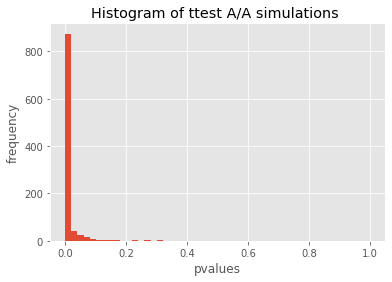

0.927

In [73]:
# проведем A/A-тест, результатом будем процент выборок, где различие было статистически значимо
# таким образом, если результат будет выше 0.05, то количество статистически значимо различных выборок больше 5 %
# и наоборот, если меньше 0,05, то меньше 5% выборок из всего числа статистически значимо отличаются
# следовательно, нам необходимо получить значение меньше 0.05, тогда сплит система будет работать корректно
# n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = mobile_app.query('experimentVariant == 0').purchase.sample(n_s, replace = False).values
    s2 = mobile_app.query('experimentVariant == 1').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

В итоге можно сделать вывод, что система сплитования работает не верно, так как FPR > альфа, которая равна 0.05. Мы получаем статистически значимые различия в 92% случаев, так быть не должно. Необходимо найти причину. Сначала проверим данные на дисбаланс в группах, потом сделаем проверку FPR с помощью бизнес-метрики convertion.

# Найдем причину поломки системы сплитования

проверим данные на дисбаланс в группах

In [74]:
# уже можно заметить, что различия в группах присутствуют
mobile_app.groupby('experimentVariant', as_index=False).agg({'purchase': 'mean'})

,experimentVariant,purchase
0,0,0.023945
1,1,0.053242


In [75]:
# сгруппируем данные по группе, версии и тому, сделали они покупку или нет
balance = mobile_app \
            .groupby(['experimentVariant', 'version', 'purchase'], as_index=False) \
            .agg({'uid': 'count'}) \
            .rename(columns=({'uid': 'quantity'}))

In [76]:
# сделаем новую колонку, туда запишем долю пользователей от группы
# разделим количество в группе на общее количество юзеров в группе и умножим на 100, чтобы получился процент
# так как там примерно 50% на 50% по двум группам, то можно общее количество разделить пополам
balance['share_group'] = (balance.quantity / (mobile_app.shape[0]/2)) * 100

In [77]:
# посмотрим на то, какое распределение пользователей по версиям в группах
# видно, что процент везде почти одинаковый, значит баланс количества по версиям в группах равный
balance.pivot_table(index='experimentVariant', columns='version', values='share_group')

version,v2.8.0,v2.9.0,v3.7.4.0,v3.8.0.0
experimentVariant,,,,
0,32.501693,9.385284,3.309767,4.482829
1,32.713474,9.473460,3.323151,4.810342


In [78]:
# теперь посмотрим на пропорции между группами, версиями и совершением покупки
# видна разница между количеством пользователей по версии v2.8.0, наблюдается дисбаланс
# в остальных группах пропорции примперно равны
balance.pivot_table(index='experimentVariant', columns=['version', 'purchase'], values='share_group')

version               v2.8.0               v2.9.0            v3.7.4.0  \
purchase                   0         1          0         1         0   
experimentVariant                                                       
0                  64.938828  0.064558  17.369192  1.401376  6.222740   
1                  62.443118  2.983829  17.595931  1.350990  6.227464   

version                      v3.8.0.0            
purchase                  1         0         1  
experimentVariant                                
0                  0.396794  8.449196  0.516462  
1                  0.418838  9.016045  0.604639

теперь сделаем проверку FPR с помощью бизнес-метрики convertion

In [79]:
# сгруппируем данные по группе и версии
# посчитаем среднюю по колонке purchase
conversion = mobile_app \
            .groupby(['experimentVariant', 'version'], as_index=False) \
            .agg({'purchase': 'mean'})

In [80]:
# можно увидеть, что конверсии везде почти одинаковые между версиями в группамах, кроме версии v2.8.0
# если в группе 0 конверсия 0.000993, то в группе 1 конверсия 0.045606
conversion.pivot_table(index='experimentVariant', columns='version', values='purchase')

version,v2.8.0,v2.9.0,v3.7.4.0,v3.8.0.0
experimentVariant,,,,
0,0.000993,0.074658,0.059943,0.057604
1,0.045606,0.071304,0.063018,0.062848


Теперь проверим на значимость данных по группам при помощи многофакторной ANOVA. Если данные между группой будут значимо отличаться, тогда p_value будет меньше 0.05.

In [81]:
# для удобства сделаем новую колонку, где сделаем комбинацию группы и версии
# так как номер группы записан в числовом типе данных, сначала необходимо перевести в str и сложить через / с версией
mobile_app['combination'] = mobile_app.astype({'experimentVariant': 'str'}).experimentVariant + '/' + mobile_app.version

In [82]:
# сделаем проверку на равность между группами
# нам необходимо смотреть на результаты между разнуми группами, но одной версией (такие по индексам: 3, 10, 16, 21)
# можно увидеть, что значимое отличие между группами есть только с версией v2.8.0, т.к. pval меньше 0.05
pg.pairwise_gameshowell(data=mobile_app, dv="purchase", between="combination")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,0/v2.8.0,0/v2.9.0,0.000993,0.074658,-0.073665,0.002412,-30.535925,12019.005923,0.001000,-0.317494
1,0/v2.8.0,0/v3.7.4.0,0.000993,0.059943,-0.058950,0.003665,-16.085214,4218.080870,0.001000,-0.260403
2,0/v2.8.0,0/v3.8.0.0,0.000993,0.057604,-0.056611,0.003092,-18.309762,5721.728590,0.001000,-0.258836
3,0/v2.8.0,1/v2.8.0,0.000993,0.045606,-0.044612,0.001035,-43.097052,43456.485244,0.001000,-0.299481
4,0/v2.8.0,1/v2.9.0,0.000993,0.071304,-0.070311,0.002351,-29.905501,12137.246569,0.001000,-0.309814
5,0/v2.8.0,1/v3.7.4.0,0.000993,0.063018,-0.062025,0.003744,-16.567322,4234.508163,0.001000,-0.267717
6,0/v2.8.0,1/v3.8.0.0,0.000993,0.062848,-0.061855,0.003109,-19.896041,6139.489549,0.001000,-0.272716
7,0/v2.9.0,0/v3.7.4.0,0.074658,0.059943,0.014715,0.004382,3.358046,8089.205106,0.017960,0.060232
8,0/v2.9.0,0/v3.8.0.0,0.074658,0.057604,0.017054,0.003916,4.355407,12509.339983,0.001000,0.070160
9,0/v2.9.0,1/v2.8.0,0.074658,0.045606,0.029053,0.002616,11.105974,16464.009309,0.001000,0.115389


В итоге можно сделать вывод, что группа с версией v2.8.0 делает работу А/А-теста некорректной. Такая группа не репрезентативная, потому что имеет дисбаланс, а так же видимые отличия при проверке бизнес метрикой и значение p_value меньше 0.05 при проверке на равность групп. Следовательно, нужно провести A/A-тест без этой группы и посмотреть результат.

# Проведем A/A-тест без группы с версией v2.8.0

In [83]:
# отфильтруем группу с версией v2.8.0
without_one_version = mobile_app.query('version != "v2.8.0"')

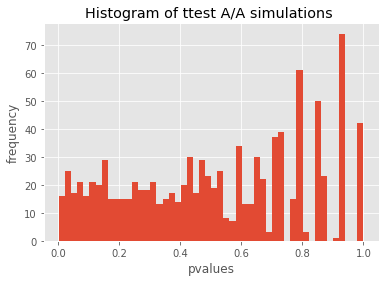

0.049

In [84]:
# проведем A/A-тест, результатом будем процент выборок, где различие было статистически значимо
# таким образом, если результат будет выше 0.05, то количество статистически значимо различных выборок больше 5 %
# и наоборот, если меньше 0,05, то меньше 5% выборок из всего числа статистически значимо отличаются
# следовательно, нам необходимо получить значение меньше 0.05, тогда сплит система будет работать корректно
# n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = without_one_version.query('experimentVariant == 0').purchase.sample(n_s, replace = False).values
    s2 = without_one_version.query('experimentVariant == 1').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

В итоге можно сделать вывод, что, при наличии группы с версией v2.8.0, система сплитования работает не корректно. Без этой группы значение FPR меньше 0.05, приблизительно 0.04. Это говорит о том, что теперь данные прошли проверку на A/A-тест.